Что вообще нужно: http://philologos.narod.ru/vekshin/vekshin-metaphony.pdf

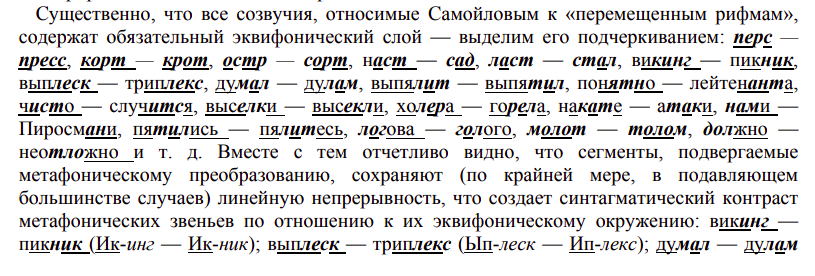

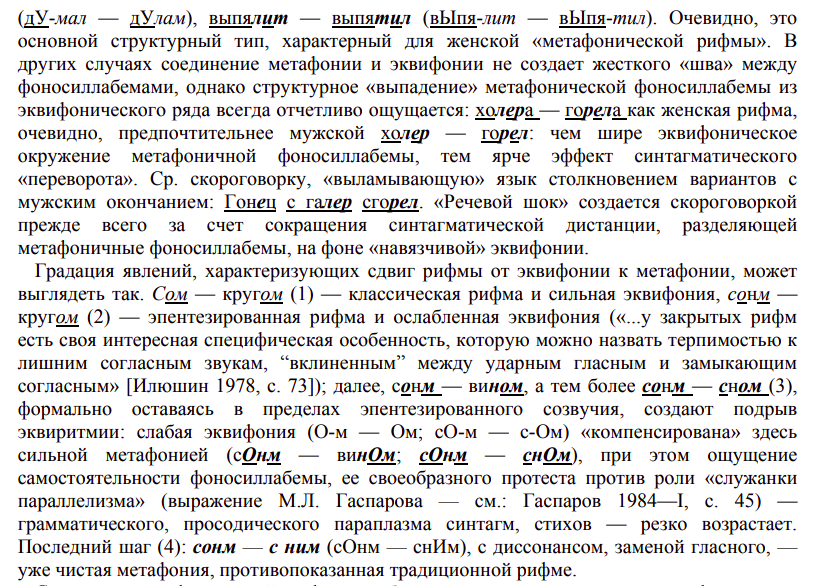

! важен порядок следования
«Какая свадьба без матроса, / Какая свалка без матраса»

ПРЕДЛОЖЕНИЕ:

искать по слогам - до следующей гласной или пробела

считаем, что экфифония не зависит от гласного:
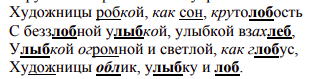


Задаем поиск в строке "похожей" подстроки на шаблон

Не забыть !!! мб надо поменять "похожие" буквы на спецсимволы - тс уж точно - в процессе алгоритма или сначала проверить строку? - поменять все т на д? или фонетику сделать?

сначала задаем похожие буквы

In [2]:
class Letter():
    ''' класс букв'''

    def __init__(self, char, vchar = None):
        self.origin = char if vchar is None else vchar
        self.technic = char
        
        #self.printable = char
        self.is_consonant = False
        self.is_volve = False
        self.is_let = False
        self.syll = 0 # в каком слоге буква
        self.pwr = 0
        self.number = 0 # какой по счету звук в строке
        self.word = 0 # в каком слове буква
        self.dist = None

    def __str__(self):
        return self.origin + '(' + "".join([self.technic]) + ')'

    def __repr__(self):

        return "     '     ".join([
            self.origin,
            str(self.technic),
            'C' if self.is_consonant else '-',
            'V' if self.is_volve else '-',
            "да" if self.is_let else '-',
            str(self.syll),
            str(self.number),
            str(self.word),
            str(self.pwr),
            str(self.dist)
        ])

In [3]:
class Phonotext():
    ''' преобразование текста в последовательность объектов класса Letter '''

    def __init__(self, text, visual_text = None):
        if type(text) == str:
            text = [x for x in text.lower()]

        if type(text[0]) == Letter:
            self.basetext = text
        elif visual_text is None:
            self.basetext = [Letter(x) for x in text]
           
        else:
            self.basetext = [Letter(x, y) for x, y in zip(text, visual_text)]

        

    def count_letters(self):
        count_symbols = count_volves = 0
        for symb in self.basetext:
            if symb.is_consonant:
                count_symbols += 1
            if symb.is_volve and symb.technic not in ["--endl",'\n']:
                count_volves += 1
                count_symbols += 1
        return count_volves, count_symbols

    
    def __getitem__(self, item):
        if isinstance(item, slice):
            # Создание нового объекта данного класса с элементами среза внутреннего списка
            return self.__class__(self.basetext[item.start:item.stop:item.step]) #  Phonotext!
            # или return self.__class__(self.__lst[item]))
        else:
            return self.basetext[item]

    def get_origin(self):
        return ''.join([x.origin for x in self.basetext])

    def get_technic(self):
        return ''.join([x.technic for x in self.basetext])

    '''
    def get_printable(self):
        return ''.join([x.printable for x in self.basetext])
    '''
    def __repr__(self):
        return '\n'.join([repr(x) for x in self.basetext])

    def __len__(self):
        return len(self.basetext)



In [4]:
class Node:
    def __init__(self, value, nxt=None):
        self.value = value
        self.nxt = nxt

    def get_value(self):
        return self.value

    def get_next(self):
        return self.nxt

class LinkedLiset:
    def __init__(self):
        self.start = None
        self.length = 0
        self.last = None

    def add(self, value):
        elem = Node(value)
        if self.start is None:
            self.start = elem
            self.last = elem
        else:
            self.last.nxt = elem
            self.last = elem
        self.length += 1

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError("Index out of range")
        current = self.start
        for i in range(idx):
            current = current.get_next()
        return current.get_value()

    def __iter__(self):
        self.__curr = self.start
        return self

    def __next__(self):
        if self.__curr is None:
            raise StopIteration()
        val = self.__curr.get_value()
        self.__curr = self.__curr.get_next()
        return val

In [5]:
import abc 

class AbstractEvent(abc.ABC):
    '''
    Abstract event call
    '''
    @abc.abstractmethod
    def __init__(self):
        pass
class TextProcessorHandler():
    def __init__(self, succesor=None):
        self.__succesor = succesor

    def handle(self, obj, conf):
        if self.__succesor is not None:
            return self.__succesor.handle(obj, conf)   

ZERO_SPACE = u'\u200B'


In [6]:
class SameEvent(AbstractEvent):
    # делает словарь одинаковых элементов - правило соотнесения
    def __init__(self, rules):
        self.rules = dict()
        for r in rules:
            for ch in r:
                self.rules[ch] = r[0]

class SameProcessor(TextProcessorHandler):
    def handle(self, obj, conf):
        if isinstance(conf, SameEvent):
            #если заданы правила определения одинаковых букв
            for i in range(len(obj.basetext)):
                #basetext - список букв
                if obj.basetext[i].is_consonant and obj.basetext[i].origin in conf.rules.keys():
                    if (i+1 == len(obj.basetext) or (not obj.basetext[i+1].is_let)):
                        obj.basetext[i].technic = conf.rules.get(obj.basetext[i].technic, ZERO_SPACE)
                    elif obj.basetext[i+1].is_consonant and obj.basetext[i+1].origin in conf.rules.values():
                         obj.basetext[i].technic = conf.rules.get(obj.basetext[i].technic, ZERO_SPACE)
                        
                elif not obj.basetext[i].is_let:
                    obj.basetext[i].technic = conf.rules.get(obj.basetext[i].technic, ZERO_SPACE)
                #если нет ключа - возвращет ZERO_SPASE, если есть - в техническом похожая буква

        else:
            super().handle(obj, conf) #????

In [7]:
class NumberEvent(AbstractEvent):
    def __init__(self, volves, consonants):
        #задает правило согласных и гласных, а также все что буква
        self.volves = set(volves)
        self.consonants = set(consonants)
        self.words = self.volves.union(self.consonants)

class NumberProcessor(TextProcessorHandler):
    def handle(self, obj, conf):
        if isinstance(conf, NumberEvent):
            i = 0 #позиция буквы в тексте
            j = 1 #какой слог
            k = 1 #какое слово
            num = 1 #какая буква в слове
            space = False
            # print(conf.volves, conf.consonants)

            for l_number in range(len(obj.basetext)):
                #для каждой буквы - задается класс
                letter = obj.basetext[l_number]
                letter.number = i #какая буква по порядку в тексте 
                letter.word = k  #какое слово
                letter.w_pos = [num, 0] #позиция буквы в слове ?
                # print(' ', letter.technic, letter.printable, sep='', end='')
                if letter.technic in " |\n": #если что-то по аналогу пробела
                    if not space:
                        #добавляем новое слово
                        k += 1
                        if num < 3: # если предыдущее меньше 3 - по сути из одной буквы
                            while num > 1: #  по сути из одной буквы
                                num -= 1
                                #предыдущей задается [0, 0]
                                obj.basetext[l_number - num].w_pos = [0, 0]
                                num -= 1
                        while num > 1:
                            num -= 1
                            obj.basetext[l_number - num].w_pos[1] = -num #[x, -x+1] [позиция от начала слова, от конца слова]
                            num -= 1

                    space = True # это пробел
                
                else:
                    space = space and letter.technic not in conf.words #??????????
                        
                if letter.technic == "\n":
                    stopper = obj.basetext[l_number - 1].syll - 3 # в каком слоге предыдущая буква - 3
                    tmp = 1
                    while obj.basetext[l_number - tmp].syll > stopper and obj.basetext[l_number - tmp].technic != "\n":
                        #пока не пройдем на 3 слога назад и не найдем еще один перенос строки
                        obj.basetext[l_number - tmp].p_end = 1 #у этой буквы позиция конца рядом?
                        tmp += 1
                if letter.technic in conf.volves:
                    # print(0, end='')
                    letter.is_volve = True #задаем атрибут 
                    letter.is_let = True
                    letter.syll = j
                    j += 1 #еще одна гласная буква в слове - еще один слог
                elif letter.technic in conf.consonants:
                    
                    # print(1, end='')
                    letter.is_consonant = True
                    letter.is_let = True
                    letter.syll = j #эта буква в таком-то слоге
                else:
                    letter.syll = 0
                    j += 1
                i += 1 #еще одна буква в тексте
                num += 1 #еще одна буква в слове
            # print()
        else:
            super().handle(obj, conf) #???

In [8]:
from collections import defaultdict

class JoinEvent(AbstractEvent):
    def __init__(self, rules):
        self.rules = defaultdict(dict)
        for a in rules:
            self.rules[a[1]] = a[0]


class JoinProcessor(TextProcessorHandler):
    def handle(self, obj, conf):
        if isinstance(conf, JoinEvent):
            i = 1
            while i < len(obj.basetext): #проверяем предыдущую и эту в правилах
                tmp_a = obj.basetext[i - 1].origin
                tmp_b = obj.basetext[i].origin
                if tmp_a + tmp_b in conf.rules.keys() or tmp_b == u"\u0301":
                    obj.basetext[i - 1].origin = tmp_a + tmp_b
                    #obj.basetext[i - 1].printable = tmp_a + tmp_b
                    
                    obj.basetext[i - 1].technic = conf.rules[tmp_a + tmp_b]
                    obj.basetext.pop(i)
                    i -= 1
                i += 1
        else:
            super().handle(obj, conf)

In [9]:
class ModifyEvent(AbstractEvent):
    def __init__(self, rules):
        self.rules = defaultdict(dict)
        for a in rules:
            self.rules[a[0]][a[1]] = rules[a]


class ModifyProcessor(TextProcessorHandler):
    def handle(self, obj, conf):
        if isinstance(conf, ModifyEvent):
            i = 1
            while i < len(obj.basetext):
                tmp_a = obj.basetext[i - 1].origin
                tmp_b = obj.basetext[i].origin
                if tmp_a in conf.rules:
                    if tmp_b in conf.rules[tmp_a]:
                        tmp_c = conf.rules[tmp_a][tmp_b]
                        obj.basetext.insert(i, Letter(ZERO_SPACE))
                        obj.basetext[i - 1].technic = tmp_c[0]
                        obj.basetext[i + 0].technic = tmp_c[1]
                        obj.basetext[i + 1].technic = tmp_c[2]
                i += 1
        else:
            super().handle(obj, conf)

In [10]:
import yaml

def load_config(filename):
    '''
    заргужаем yaml с русским
    '''
    with open(filename, 'r', encoding="utf-8") as stream:
        try:
            config = yaml.load(stream, Loader=yaml.FullLoader)
            return [
                JoinEvent(config['as_one']),
                NumberEvent(config['volves'], config['consonants']),
                ModifyEvent(config['modifications']),
                SameEvent( config['as_same'])
            ]
            # return config
        except yaml.YAMLError as exc:
            print(f'ERROR {exc}')

        return None
    
def config(file, *text):

    PROCESSOR = TextProcessorHandler()
    PROCESSOR = JoinProcessor(PROCESSOR)
    PROCESSOR = NumberProcessor(PROCESSOR)
    PROCESSOR = ModifyProcessor(PROCESSOR)
    PROCESSOR = SameProcessor(PROCESSOR)
    
    for i in load_config(file):
        for t in text:
            PROCESSOR.handle(t, i)

Добавить ударность, безударность в технические гласных

In [11]:
import pandas as pd

def imp_csv(file):
    weight = pd.read_csv(file , sep = ',')

    weight.rename(columns={ weight.columns[0]: "0" }, inplace = True)
    weight.index = [i for i in weight["0"]]
    del weight['0']
    return weight

imp_csv('1.csv') 

б      п      д      т      г      к      в      ф      з      с  ...  \
б  0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
п  0,50   0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
д  1,00   1,12   0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
т  1,12   1,00   0,50   0,00     NaN    NaN    NaN    NaN    NaN    NaN  ...   
г  1,00   1,12   1,00   1,12   0,00     NaN    NaN    NaN    NaN    NaN  ...   
к  1,12   1,00   1,12   1,00   0,50   0,00     NaN    NaN    NaN    NaN  ...   
в  1,25   1,35   1,60   1,68   1,60   1,68   0,00     NaN    NaN    NaN  ...   
ф  1,35   1,25   1,68   1,60   1,68   1,60   0,50   0,00     NaN    NaN  ...   
з  1,80   1,87   1,80   1,87   1,80   1,87   1,50   1,58   0,00     NaN  ...   
с  1,87   1,80   1,87   1,50   1,87   1,80   1,58   1,50   0,50   0,00   ...   
ж  1,95   2,02   1,95   2,02   1,95   2,02   1,68   1,75   0,75   0,90   ...   
ш  2,02   1,95   2,02   1,95   2,02   1,95   1,75   1,68   0,90   0,75   ...   
щ  2,08   2,02   2,08   2,02   2,08   2,02   1,82   1,75   1,03   0,90   ...   
й  1,84   1,77   1,84   1,77   1,84   1,46   2,22   2,17   2,37   2,17   ...   
х  1,35   1,25   1,35   1,25   0,90   0,75   1,84   1,77   2,02   1,95   ...   
ц  1,68   1,60   1,35   1,25   1,58   1,50   2,42   2,37   1,90   1,00   ...   
ч  1,68   1,60   1,35   1,25   1,68   1,60   2,08   2,02   1,44   1,35   ...   
м  1,50   1,58   1,80   1,87   1,80   1,87   1,50   1,58   2,35   2,40   ...   
н  1,68   1,75   1,50   1,58   1,80   1,87   1,75   1,82   2,35   2,40   ...   
л  1,95   2,02   1,80   1,87   2,06   2,12   2,02   2,08   2,55   2,60   ...   
р  2,09   2,15   1,95   2,02   2,19   2,25   2,15   2,21   2,66   2,70   ...   

       ш      щ      й      х      ц      ч      м      н      л      р  
б    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
п    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
д    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
т    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
г    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
к    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
в    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
ф    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
з    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
с    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
ж    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
ш  0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
щ  0,50   0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
й  2,17   2,22   0,00     NaN    NaN    NaN    NaN    NaN    NaN    NaN  
х  2,09   2,15   1,25   0,00     NaN    NaN    NaN    NaN    NaN    NaN  
ц  1,68   1,60   1,60   2,03   0,00     NaN    NaN    NaN    NaN    NaN  
ч  1,12   1,00     NaN  1,68   1,25   0,00     NaN    NaN    NaN    NaN  
м  2,51   2,70   2,37   2,02   2,25     NaN  0,00     NaN    NaN    NaN  
н  2,51   2,70   2,37   2,02   2,02     NaN  0,75   0,00     NaN    NaN  
л  2,70   2,88   2,57   2,25   2,25     NaN  1,25   1,00   0,00     NaN  
р  2,81   2,98   2,68   2,37   2,37     NaN  1,46   1,25   0,75   0,00   

[21 rows x 21 columns]

In [12]:
def weight(pattern_letter, text_letter):
    if isinstance(pattern_letter, Letter) and isinstance(text_letter, Letter):
        if pattern_letter.is_volve and text_letter.is_volve:
            if not pattern_letter.technic.isupper() and not text_letter.technic.isupper():
                return 0 #пока так? что с пробелами надо придумать и что с ударениями - и если поставить как 0 -сбивается алгоритм
            elif pattern_letter.technic == text_letter.technic:
                return 0
            else: 
                return 1
        elif pattern_letter.is_consonant and text_letter.is_consonant:
            a = pattern_letter.technic
            b = text_letter.technic
            data = imp_csv('1.csv')
            count =[data[a][b], data[b][a]]
            for i in count:
                if not pd.isna(i):
                    i = i.split(',')
                    i = '.'.join(i)
                    return float(i)
            return 1 #тоже пока
        else:
            return 1.5 #тут замены согласных на гласные и тд
  

In [16]:
def distance(let1, let2):
#Calculates the Levenshtein distance between let1 and let2
    
    n, m = len(let1), len(let2)

    current_column = range(n+1) # Keep current and previous column, not entire matrix
    for i in range(1, m+1):
        previous_column, current_column = current_column, [i]+[0]*n
        for j in range(1,n+1):
            add, delete, change = previous_column[j]+1, current_column[j-1]+1, previous_column[j-1]
            #добавление или удаление гласной - нарушает структуру слова
            if let1[j-1].is_volve:
                 add += 2
            elif let2[i-1].is_volve:
                 delete += 2
            if let1[j-1].technic != let2[i-1].technic:
                change += weight(let1[j-1], let2[i-1])
           # print(let1[j-1], let2[i-1], add, delete, change)
            current_column[j] = min(add, delete, change)

    return current_column[n]

In [14]:
#алгоритм Нидлмана-Вунша поиска подпоследовательности
def fill_matrix(x, y):
    M = [[0]*(len(y)+1) for _ in range(len(x)+1)]
    for x_cur in range(len(x)):
        for y_cur in range(len(y)):
            if weight(x[x_cur], y[y_cur]) < 1:
                M[x_cur][y_cur] = M[x_cur-1][y_cur-1] + 1
            else:
                M[x_cur][y_cur] = max((M[x_cur][y_cur-1],M[x_cur-1][y_cur]))
    return M

def LCS_DYN(x, y, d):
    M = fill_matrix(x, y)
    LCSx = []
    LCSy = []
    x_cur,y_cur = len(x)-1,len(y)-1
    while x_cur >= 0 and y_cur >= 0:
        if weight(x[x_cur], y[y_cur]) < 1:
            LCSx.append(x[x_cur])
            LCSy.append(y[y_cur])
            if x[x_cur].dist is None or x[x_cur].dist > d:
                x[x_cur].pwr, y[y_cur].pwr = y[y_cur].number, x[x_cur].number
                x[x_cur].dist, y[y_cur].dist = d, d
            x_cur, y_cur = x_cur-1, y_cur-1
        elif M[x_cur-1][y_cur] > M[x_cur][y_cur-1]:
            x_cur -= 1
        else:
            y_cur -= 1
    LCSx.reverse()
    LCSy.reverse()
    return LCSx, LCSy, x, y

Вывод в формате: (расстояние Левенштейна, начало похожего фрагмента, конец, похожий фрагмент, шаблон)

Для анализа и выделеия - фрагменты с малым расстоянием

Теперь нужно разбить первую строку на "шаблоны" (LinkedList?)

И ввести веса за замену букв, например, д и т - похожие буквы, замены гласных не критичны. 

Возможно стоит модернизировать так, чтобы замена

Важно, что написанный алгоритм устойчив относительно вставки буквы в шаблоне, но не в строке (то есть надо переписать так, что "молодой", "моглодой" и "золотой" имели "*?оло*?ой" и "*?о*?ло*?ой"
и можно было искать "слабую" эквифонию

In [41]:
def union(text):
    res = []
    n = 0
    for colloc in text:
        for let in range(len(colloc)):
            if colloc[let].number == n:
                for i in range(let, len(colloc)):
                    res.append(colloc[i])
                break
        n = res[-1].number + 1
    return Phonotext(res)

In [44]:
from accents import *

def splitting(text):
    lst = LinkedLiset()
    i  = 0
    if len(text) < 5:
        lst.add(text.basetext)
        i += 1
    while i != len(text):
        if i+5 <= len(text):
            if i == 0 or text[i].is_consonant or not text[i-1].is_let:
                lst.add(text[i:i+5])
            i += 1
            
        else:
            if text[i].is_consonant or not text[i-1].is_let:
                lst.add(text[i::])
                
            i+=1
                
    return lst

def differ(str1, str2):
    
    str1 = get_accents_stat(str1)
    str2 = get_accents_stat(str2)
    
    str1 = Phonotext(str1)
    str2 = Phonotext(str2)
    
    config("russian.yaml", str1, str2)
        
    s1 = splitting(str1)
    s2 = splitting(str2)
    

    
    for coll1 in s1: #мб тут лучше и быстрее матрица numpy
        for coll2 in s2:
            #print(t2[1][1].technik)
            d = distance(coll1, coll2)
            if d <= 2:
                a, b, coll1, coll2 = LCS_DYN(coll1, coll2, d)
                i1 = ''.join([x.technic for x in coll1])
                i2 = ''.join([x.technic for x in coll2])
                a = ','.join([x.technic for x in a])
                b = ','.join([x.technic for x in b])
                print(f"Расстояние между {i1} ({a}) и {i2} ({b}) составляет {d} - это похожая часть исходных строк")
    return s1, s2
                           

text = "молодой козёл"
pattern = "золотой осёл" #доделать возможность ввода ударений черз верхний регистр

text, pattern = differ(text, pattern)
print(union(text), "\n", union(pattern))



Расстояние между лодОй (л,о,д,О,й) и лотОй (л,о,т,О,й) составляет 0.5 - это похожая часть исходных строк
Расстояние между дОй|к (д,О,й) и тОй|о (т,О,й) составляет 2.0 - это похожая часть исходных строк
Расстояние между козЁл (о,з,Ё,л) и осЁл (о,с,Ё,л) составляет 1.5 - это похожая часть исходных строк
Расстояние между зЁл (з,Ё,л) и осЁл (с,Ё,л) составляет 1.5 - это похожая часть исходных строк
Расстояние между зЁл (з,Ё,л) и сЁл (с,Ё,л) составляет 0.5 - это похожая часть исходных строк
Расстояние между зЁл (л) и л (л) составляет 2 - это похожая часть исходных строк
Расстояние между л (л) и сЁл (л) составляет 2 - это похожая часть исходных строк
Расстояние между л (л) и л (л) составляет 0 - это похожая часть исходных строк
м     '     м     '     C     '     -     '     да     '     1     '     0     '     1     '     0     '     None
о     '     о     '     -     '     V     '     да     '     1     '     1     '     1     '     0     '     None
л     '     л     '     C     '     -     

Объединять подряд идущие гласные (нейотированные,) -\pm

Расставить ударные гласные - done

Объединить результат в виде выделенных букв (мб сделать пометку в Letter()) там по слогам и тд - \pm

Ещё предстоит разобраться с ударениями(и гласными вообще) и с "читабельным" выводом результатов. - done \pm

Если считать замену гласных на гласные - done

Нужно обыграть удвоение и подряд идущие гласные \pm

Возможно имеет смысл переназначить "вес" удаления из строки, с которой сравнивается пятибуквие. - done

И все-таки лучше разбивать каждую строку на пятерки(и менее), а затем их сравнивать - иначе наложение -  потом выбирать наиболее подходящие - done

Поправить LinkedList, чтобы был вызов по индексу - done


In [213]:
import numpy as np

def fisher_wagner(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    for x in range(size_x):
        matrix[x, 0] = x
    for y in range(size_y):
        matrix[0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1)
                
            else:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,     # удаление
                    matrix[x-1, y-1] + 1,   # замена
                    matrix[x, y-1] + 1)     # вставка
    
    return matrix

fisher_wagner("сом", "м")

array([[0., 1.],
       [1., 1.],
       [2., 2.],
       [3., 2.]])

In [252]:
'''
def distance_more(text, pattern):
    min_value, end_pos, a1, b1 = distance(text, pattern)
    min_value, start_pos, a2, b2 = distance(text[end_pos-1::-1], pattern[::-1])
    start_pos = end_pos - start_pos
    #print(''.join([x.technic for x in text]))
    return min_value, start_pos, end_pos,\
''.join([x.technic for x in text]),\
''.join([x.technic for x in pattern]),\
''.join([x.technic for x in text[start_pos:end_pos]]),\
b1, a1


def dist(text, pattern):
    #для учета порядка не только букв подряд
    result = distance_more(text, pattern)
    
    return (result)
    """
    a1 = Phonotext("".join(result[5]))
    b1 = Phonotext("".join(result[6]))
    config("russian.yaml", a1, b1)
    return list(distance_more(a1, pattern)[3]),list(distance_more(b1, pattern)[3])
    """
'''
#тут тоже можно в а1 поиск поиск "вокруг" согласных

        


In [ ]:
"""
def ekvi(text, l):
    e = []
    i = 0
    j = 0
    while i < len(text):
        if text[i].is_consonant and text[i].technic == l[j]:
            e.append(l[j])
            if j+1 <len(l):
                l = l[j+1:]
                j = -1
                i+=1
        j+=1
        if j == len(l):
            i += 1
            j = 0
        
    return e

def dist(text1, text2):
    dis, a, b  = distance(text1,text2)
    print("Расстояние: {}, похожие буквы в первой строке: {}, похожие буквы во второй строке{}". format(dis, a, b))
    if dis <= 2:
        print("Сравнение похожих с первой строкой: {}, сравнение похожих со второй строкой {}".format(ekvi(text1, a), ekvi(text2, b)))
    return (dis, ''.join([x.technic for x in text1]),''.join([x.technic for x in text2]), a, b) 


ekvi(text1, a1)
ekvi(text2, b1)
ekvi(text1, b2)
ekvi(text2, a2)
"""
    

In [79]:
import yaml

acc = u"\u0301"
accents = [
    f'[А, {"а" + acc}]', f'[О, {"о" + acc}]', 
    f'[Ы, {"ы" + acc}]', f'[Е, {"е" + acc}]',
    f'[Ю, {"ю" + acc}]', f'[Я, {"я" + acc}]',
    f'[У, {"у" + acc}]', f'[Ё, {"ё" + acc}]',
    f'[И, {"и" + acc}]', f'[Э, {"э" + acc}]'
]

to_yaml = {'accents': accents}

with open('russian.yaml','r') as f:
        cur_yaml = yaml.load(f)
        cur_yaml.update(to_yaml)
        print(cur_yaml)

with open('russians.yaml','w') as f:
        yaml.safe_dump(cur_yaml, f,  allow_unicode=True) # Also note the safe_dump
"""
with open('russians.yaml', '+w') as f:
     f.write(yaml.dump(to_yaml, allow_unicode = True, default_flow_style=False))
    
with open('russians.yaml') as f:
    print(f.read())
"""

{'volves': ['--endl', '\n', 'ё', 'Ё', 'у', 'У', 'е', 'Е', 'ы', 'Ы', 'а', 'А', 'о', 'О', 'э', 'Э', 'я', 'Я', 'и', 'И', 'ю', 'Ю'], 'consonants': ['ш', 'щ', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'j', 'й', 'к', 'л', 'м', 'н', 'п', 'б', 'в', 'г', 'д', 'ж', 'з', 'тс'], 'alphabet': 'аАбвгдеЕёЁжзиИйклмноОпрстуУфхцчшщыЫэЭюЮяЯ', 'as_same': [['--endl', '\n'], ['|', ' '], [], 'пб', 'фв', 'тд', 'сз', 'йj', 'шж', 'кг', ['ц', 'тс']], 'as_one': [['ц', 'тс'], ['Ё', 'u"ё\\u301"'], ['О', 'u"о\\u301"'], ['Ы', 'u"ы\\u301"'], ['Е', 'u"е\\u301"'], ['Ю', 'u"ю\\u301"'], ['Я', 'u"я\\u301"'], ['У', 'u"у\\u301"'], ['А', 'u"а\\u301"'], ['И', 'u"и\\u301"'], ['Э', 'u"э\\u301"']], 'modifications': {'ьи': 'ьjи', 'ъи': 'ъjи', ' е': ' jэ', 'ае': 'аjэ', 'ое': 'оjэ', 'уе': 'уjэ', 'ые': 'ыjэ', 'ие': 'иjэ', 'эе': 'эjэ', 'ье': 'ьjэ', 'ъе': 'ъjэ', 'ее': 'еjэ', 'ёе': 'ёjэ', 'юе': 'юjэ', 'яе': 'яjэ', ' ё': ' jо', 'аё': 'аjо', 'оё': 'оjо', 'уё': 'уjо', 'ыё': 'ыjо', 'иё': 'иjо', 'эё': 'эjо', 'ьё': 'ьjо', 'ъё': 'ъjо', 'её': 'еjо', 'ё

<ipython-input-79-c0a2001e0220>:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cur_yaml = yaml.load(f)


"\nwith open('russians.yaml', '+w') as f:\n     f.write(yaml.dump(to_yaml, allow_unicode = True, default_flow_style=False))\n    \nwith open('russians.yaml') as f:\n    print(f.read())\n"